# Overview

Welcome! In this notebook, I will be applying the concepts that I have learned to solve a real-world project. I'm going to work with a dataset provided by <b>Clarusway</b>, which includes a wide range of car prices and several essential features for this prediction task.

Table of content: 
-
- 
-


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, Normalizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import SCORERS, mean_absolute_error, mean_squared_error, r2_score
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.features import RadViz
from sklearn.linear_model import Ridge

%matplotlib inline

## EDA

In [3]:
df = pd.read_csv('Ready_to_ML.csv')
df.head(1)

,make_model,make,location,price,body_type,type,warranty,mileage,gearbox,fuel_type,...,full_service_history,upholstery,previous_owner,energy_efficiency_class,age,power_kW,cons_avg,comfort_&_convenience_Package,entertainment_&_media_Package,safety_&_security_Package
0,Mercedes-Benz A 160,Mercedes-Benz,"P.I. EL PALMAR C/FORJA 6, 11500 PUERTO DE SAN...",16950.0,Compact,Used,Yes,120200.0,Manual,Diesel,...,No,Cloth,2.0,efficient,6.0,75.0,3.8,Standard,Standard,Safety Premium Package


In [4]:
#checking for nulls
df.isnull().sum()

make_model                       0
make                             0
location                         0
price                            0
body_type                        0
type                             0
warranty                         0
mileage                          0
gearbox                          0
fuel_type                        0
seller                           0
engine_size                      0
gears                            0
co_emissions                     0
drivetrain                       0
extras                           0
empty_weight                     0
full_service_history             0
upholstery                       0
previous_owner                   0
energy_efficiency_class          0
age                              0
power_kW                         0
cons_avg                         0
comfort_&_convenience_Package    0
entertainment_&_media_Package    0
safety_&_security_Package        0
dtype: int64

In [5]:
# checking for duplicates
df.duplicated().sum()

1815

In [6]:
df.drop_duplicates(inplace=True)

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
price,24896.0,23267.093067,20929.617776,490.0,12480.0,17990.0,27900.00,549000.0
mileage,24896.0,67626.156910,61708.674086,0.0,19000.0,52862.5,99532.25,667128.0
engine_size,24896.0,1698.132150,789.478406,0.0,1242.0,1580.0,1969.00,6300.0
gears,24896.0,5.774582,1.407822,1.0,5.0,6.0,6.00,8.0
co_emissions,24896.0,129.384751,54.363831,0.0,106.0,123.0,150.00,399.0
empty_weight,24896.0,1409.004820,299.565866,347.0,1205.0,1365.0,1575.00,3150.0
previous_owner,24896.0,1.458507,0.849019,1.0,1.0,1.0,2.00,9.0
age,24896.0,5.128213,4.607968,0.0,2.0,4.0,7.00,20.0
power_kW,24896.0,117.265284,66.075700,33.0,77.0,97.0,132.00,450.0
cons_avg,24896.0,5.540101,2.226174,0.0,4.3,5.1,6.40,18.3


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24896 entries, 0 to 26710
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   make_model                     24896 non-null  object 
 1   make                           24896 non-null  object 
 2   location                       24896 non-null  object 
 3   price                          24896 non-null  float64
 4   body_type                      24896 non-null  object 
 5   type                           24896 non-null  object 
 6   warranty                       24896 non-null  object 
 7   mileage                        24896 non-null  float64
 8   gearbox                        24896 non-null  object 
 9   fuel_type                      24896 non-null  object 
 10  seller                         24896 non-null  object 
 11  engine_size                    24896 non-null  float64
 12  gears                          24896 non-null 

## Outliers handling

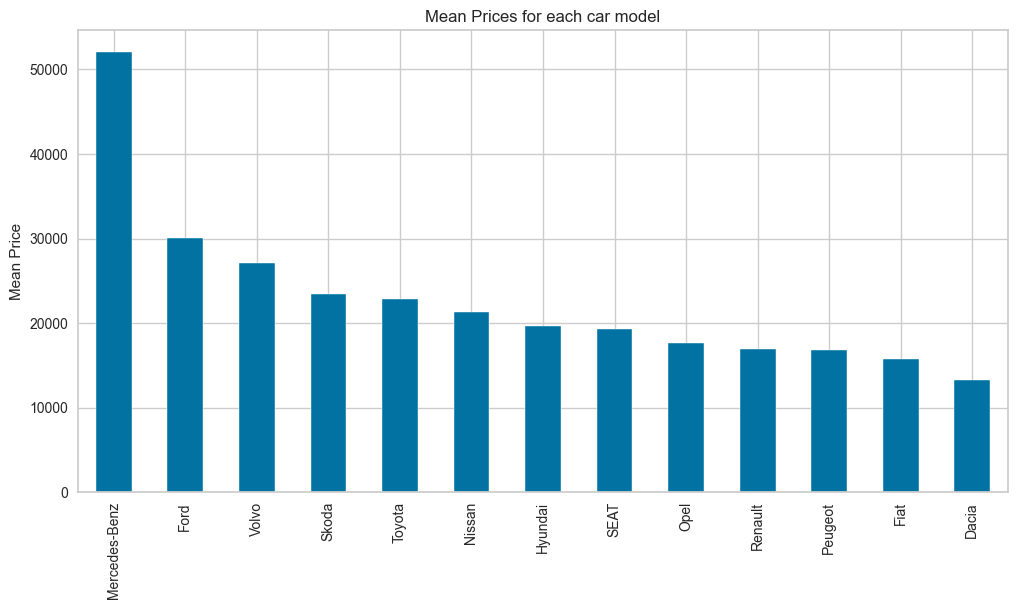

In [9]:
sns.set_style('whitegrid')

# calculate the mean price for each group
mean_prices = df.groupby('make')['price'].mean()

# sorting 
mean_prices = mean_prices.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
mean_prices.plot(kind='bar')
plt.xlabel('')
plt.ylabel('Mean Price')
plt.title('Mean Prices for each car model')
plt.xticks(rotation=90)
plt.show()

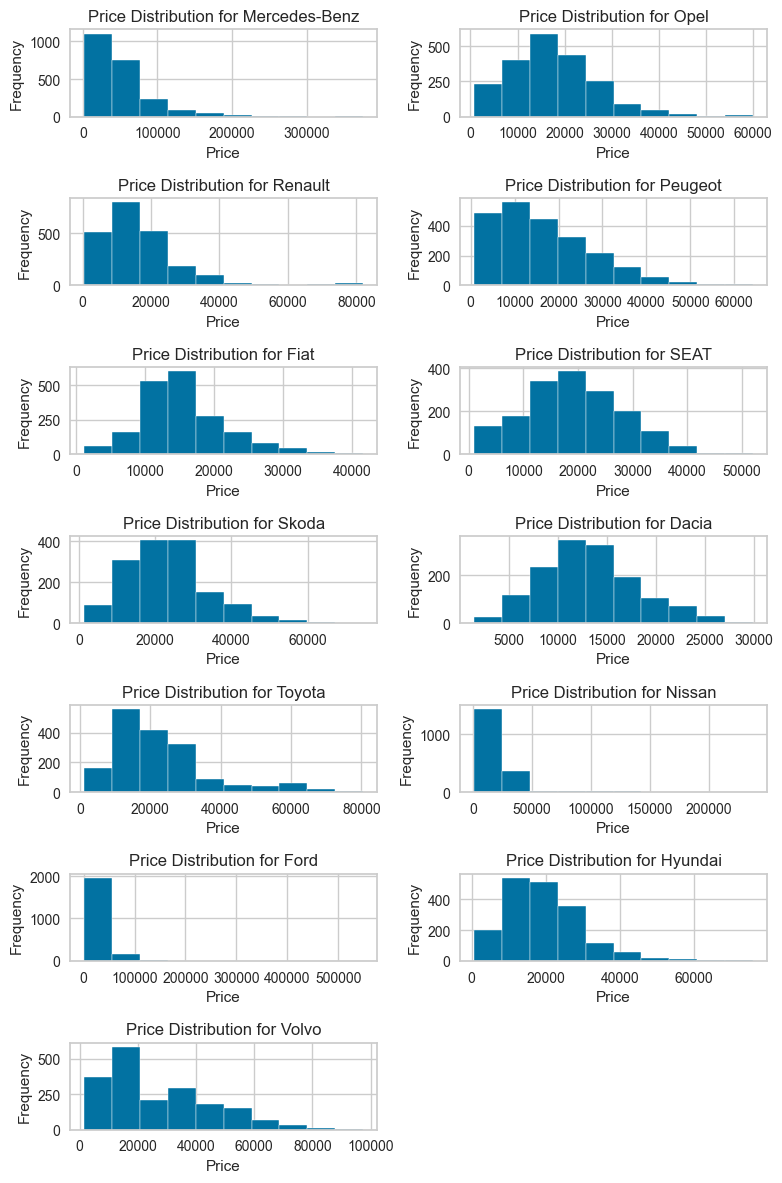

In [10]:
# store unique categories
categories = df['make'].unique()

num_rows = 7
num_cols = 2

#  subplots for each category
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 12))

axes = axes.flatten()


for i, category in enumerate(categories):
    category_df = df[df['make'] == category]

    ax = axes[i]
    
    ax.hist(category_df['price'], bins=10)
    ax.set_xlabel('Price')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Price Distribution for {category}')

if len(categories) % 2 != 0:
    fig.delaxes(axes[-1])

fig.tight_layout()

plt.show()

Our strategy for outliers handling will be to filter rows based on each car model z scores 

In [12]:
df.shape[0]

24896

In [13]:
def remove_outliers(group):
    """This function calculates the z-score for each car model 
    and filter the row based on a defined threshold

    Args:
        group (df): rows of car model

    Returns:
        group: set of rows that met the criteria
    """
    # z-scores within each group
    z_scores = (group['price'] - group['price'].mean()) / group['price'].std()

    threshold = 3
    
    # filter rows that exceeds the threshold
    filtered_group = group[abs(z_scores) <= threshold]
    
    return filtered_group


filtered_df = df.groupby('make').apply(remove_outliers).reset_index(drop=True)

In [14]:
filtered_df.shape[0]

24559

## multicollinearity control

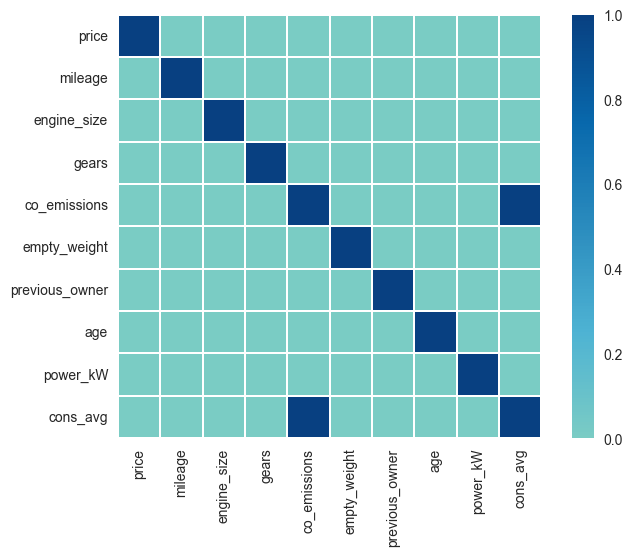

In [15]:
sns.heatmap(filtered_df.corr(numeric_only=True) >= 0.8, 
            cmap = 'GnBu', 
            linewidths=.12, 
            linecolor='white',
            fmt='.2g',
            center = 0,
            square=True);

We have two independent features with high correlation score.

## Data Preprocessing

In [16]:
# store columns with object type only
cat_columns = list(df.select_dtypes(include=['object']).columns)
cat_columns

['make_model',
 'make',
 'location',
 'body_type',
 'type',
 'warranty',
 'gearbox',
 'fuel_type',
 'seller',
 'drivetrain',
 'extras',
 'full_service_history',
 'upholstery',
 'energy_efficiency_class',
 'comfort_&_convenience_Package',
 'entertainment_&_media_Package',
 'safety_&_security_Package']

In [17]:
filtered_df['make_model'].value_counts()

Renault Megane          822
SEAT Leon               757
Dacia Sandero           721
Hyundai i30             699
Opel Astra              634
                       ... 
Hyundai Atos              1
Opel Agila                1
Opel Ampera               1
Renault R 11              1
Mercedes-Benz GL 420      1
Name: make_model, Length: 485, dtype: int64

We must reduce the number of values before one-hot encoding

In [18]:
def replace_extras(value):
    '''
    Description:
    This function gets the values of a column in a pandas dataframe as strings.
    
    INPUT:
    value - (str) row value as a string
    
    OUTPUT:
    count - (int) number of extra features
    
    '''
    count = len(value.split(', '))
    return count


filtered_df['extras'] = filtered_df['extras'].apply(replace_extras)

In [19]:
filtered_df['extras'][:5]

0    3
1    1
2    3
3    3
4    3
Name: extras, dtype: int64

In [20]:
filtered_df['make_model'].value_counts()

Renault Megane          822
SEAT Leon               757
Dacia Sandero           721
Hyundai i30             699
Opel Astra              634
                       ... 
Hyundai Atos              1
Opel Agila                1
Opel Ampera               1
Renault R 11              1
Mercedes-Benz GL 420      1
Name: make_model, Length: 485, dtype: int64

In [21]:
counts = filtered_df['make_model'].value_counts()

range_to_drop = range(1, 150)

# store values within the range
values_to_drop = counts[counts.isin(range_to_drop)]

mask = filtered_df['make_model'].isin(values_to_drop.index)

# keep the rows where the mask is False
filtered_df = filtered_df[~mask]

In [22]:
len(filtered_df['make_model'].unique())

44

In [23]:
len(filtered_df['make'].unique())

12

we will go with the 'make_model' feature and drop the make feature since it's a general representation 

In [24]:
# dropping make column
filtered_df.drop(columns = ['make'], inplace = True)

### Feature engineering for location column

In [25]:
filtered_df['location'][:2]

1            AVDA. ORIA, 6,  20160 LASARTE-ORIA, ES
13    Uellendahler Straße 564,  42109 Wuppertal, DE
Name: location, dtype: object

In [26]:
# take the country code name and remove space
filtered_df['location'] = filtered_df['location'].str.split(',').str[-1].str.strip()

In [27]:
filtered_df['location'].value_counts()

DE    6448
ES    3818
IT    1360
NL    1350
FR     821
BE     816
AT     286
LU      23
BG       1
Name: location, dtype: int64

In [28]:
pycountry.countries.get(alpha_2='FR').name

'France'

In [29]:
# replace each country code with original name
filtered_df['location'] = filtered_df['location'].apply(lambda x: pycountry.countries.get(alpha_2=x).name)

In [30]:
filtered_df['location'].value_counts()

Germany        6448
Spain          3818
Italy          1360
Netherlands    1350
France          821
Belgium         816
Austria         286
Luxembourg       23
Bulgaria          1
Name: location, dtype: int64

## Encoding

### column transformer

In [32]:
# Categories for one-hot encoder
onehot_cats = ['make_model',
                'location', 
                'body_type', 
                'type', 
                'fuel_type',
                'gearbox',
                'drivetrain',
                'upholstery', 
                'seller']

In [33]:
# Categories for ordinal encoder
efficient_cat= ['unefficient', 'efficient']
warranty_cat = ['No', 'Yes']
service_cat = ['No', 'Yes']
comfort_cat = ['Standard', 'Premium', 'Premium Plus']
enter_cat = ['Standard', 'Plus']
safety_cat = ['Safety Standard Package', 'Safety Premium Package', 'Safety Premium Plus Package']

ordinal_ordering = [ service_cat, efficient_cat, comfort_cat,enter_cat, safety_cat, warranty_cat]
ordincal_cats = ['full_service_history', 'energy_efficiency_class', 'comfort_&_convenience_Package', 
                 'entertainment_&_media_Package', 'safety_&_security_Package', 'warranty']

In [ ]:
pycountry.countries.get(alpha_2='FR').name

'France'

In [34]:
#column transformer

column_trans = make_column_transformer((
               OneHotEncoder( handle_unknown='ignore',
                              sparse_output=False), 
                              onehot_cats),
              (OrdinalEncoder(categories=ordinal_ordering, 
                              handle_unknown='use_encoded_value', 
                              unknown_value=-1), 
                              ordincal_cats),
                              remainder = 'passthrough')

### Data Splitting
Data must be splitted to train and test sets to avoid data lekage.

In [35]:
# splitting X and y
X = filtered_df.drop(columns = ['price'])
y = filtered_df['price']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

In [37]:
scaler = StandardScaler()

## Model training

In [57]:
# using Pre-defined functions from the original notebook

def train_val(y_train, y_train_pred, y_test, y_pred, model_name):
    """This function will help you get regression metrics on both train
    and test set provided.

    Args:
        model : model that is used for prediction
        X_train : Train features
        y_train : Train target
        X_test  : Test features
        y_test  : Test target

    Returns:
        Dataframe : Returns scores dataframe
    """
    scores = {
        model_name + "_train": {
            "R2": round(r2_score(y_train, y_train_pred), 2),
            "mae": round(mean_absolute_error(y_train, y_train_pred), 2),
            "mse": round(mean_squared_error(y_train, y_train_pred), 2),
            "rmse": round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)
        },
        model_name + "_test": {
            "R2": round(r2_score(y_test, y_pred), 2),
            "mae": round(mean_absolute_error(y_test, y_pred), 2),
            "mse": round(mean_squared_error(y_test, y_pred), 2),
            "rmse": round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)
        }
    }

    return pd.DataFrame(scores)


def adj_r2(y_test, y_pred, X):
    """This function gives adjusted R^2

    Args:
        y_test : Actual target
        y_pred : Predcition
        X : Features

    Returns:
        adj_r2: Adjusted R^2
    """
    r2 = r2_score(y_test, y_pred)
    n = X.shape[0]   # number of observations
    p = X.shape[1]   # number of independent variables
    adj_r2 = (1 - (1-r2)*(n-1)/(n-p-1)).round(2)
    return adj_r2




In [41]:
# Linear regression model
lm = LinearRegression()

linear_pipe = make_pipeline(column_trans, scaler, lm)

linear_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['make_model', 'location',
                                                   'body_type', 'type',
                                                   'fuel_type', 'gearbox',
                                                   'drivetrain', 'upholstery',
                                                   'seller']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['No',
                                                                              'Yes'],
                                                                             ['unefficient',
                                                                              'effi...
                                                                              'Premium '
                                                                              'Package',
                                                                              'Safety '
                                                                              'Premium '
                                                                              'Plus '
                                                                              'Package'],
                                                                             ['No',
                                                                              'Yes']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['full_service_history',
                                                   'energy_efficiency_class',
                                                   'comfort_&_convenience_Package',
                                                   'entertainment_&_media_Package',
                                                   'safety_&_security_Package',
                                                   'warranty'])])),
                ('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [42]:
y_pred = linear_pipe.predict(X_test)
y_train_pred = linear_pipe.predict(X_train)


In [58]:
ls = train_val(y_train, y_train_pred, y_test, y_pred, "linear")
ls

,linear_train,linear_test
R2,0.89,0.88
mae,2397.99,2425.39
mse,12922574.71,14175589.99
rmse,3594.80,3765.05


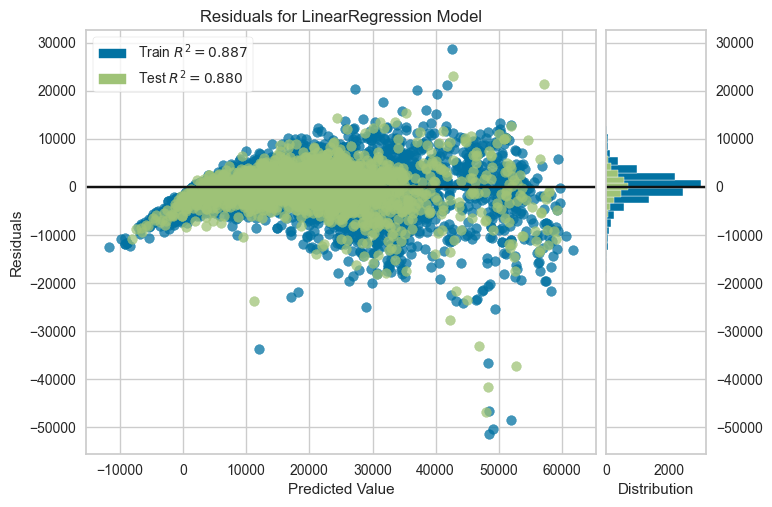

In [59]:
visualizer = ResidualsPlot(linear_pipe)

visualizer.fit(X_train, y_train)  
visualizer.score(X_test, y_test)  
visualizer.show(); 